In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import os
from os import path 
import h5py
import sys
import Initialize_Paths as Paths

# Import Reading Functions
sys.path.insert(0, Paths.Surqct_path  + '/surqct/scripts/Paper_figures/')
from Reading import read_diatdata, read_HDF5, read_pops

In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['legend.fontsize'] = 35

<ipython-input-2-cf7c5584ff04>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


# Initializing Run 

In [3]:
SystName    = 'O3_UMN'
ReactionFlgQCT    = '0_0_1_0'
ReactionFlgSurQCT = '0_0_1_0'
TempVec = [20000]
PopPlotTime = [1e-6]

# Initializing System

In [4]:
import Initialize_System
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

# Initializing Paths

In [5]:
QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath

print('QCT Master Equation Path    :', QCT_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/


# Read Diatomic Properties and Rates

In [6]:
# Read Diatomic Potentials
DiatData   = []

for iMol in range(System.NMolecules):
    DiatDataTemp = read_diatdata(System.PathToDiatFile[iMol], System.Molecule[iMol].Name, TempVec)
    DiatData.append(DiatDataTemp)
    System.Molecule[iMol].NLevels = np.size(DiatData[iMol]['EInt'].to_numpy())

Temp = TempVec[0]
# Read Rates
PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
System = read_HDF5(System, PathToHDF5File, Temp, Temp)


[HCN]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[HCN]:   Reading Rates Data from: /home/venturi/WORKSPACE/Air_Database/HDF5_Database/O3_UMN.hdf5


# Reading Master Equation Solution Files

In [7]:
QCT=[]
PopQCT = []

for iTemp in range(len(TempVec)):

    Temp = TempVec[iTemp]
    
    # QCT
    FileName=QCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgQCT+'/box.dat'
    QCTTemp=pd.read_csv(FileName,delimiter='  ')
    QCTTemp.columns = System.Box_Header
    QCT.append(QCTTemp)
    QCT[iTemp].NSteps = np.size(QCT[iTemp]['time'].to_numpy()) 

    PopFilePath=QCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgQCT
    PopTempQCT=read_pops(PopFilePath,System,DiatData,QCT[iTemp].time)
    PopQCT.append(PopTempQCT)

<ipython-input-7-f1a670f88e97>:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  QCTTemp=pd.read_csv(FileName,delimiter='  ')
/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Pop=pd.read_csv(FileName,sep="   ",skiprows=2,header=None,index_col=False,comment='&')


[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D/output_O3_UMN_T20000K_0_0_1_0


/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:105: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Pop.Pop_g = np.reshape(Pop.PopTemp.to_numpy(),(np.size(time)+1,System.Molecule[0].NLevels))
/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Pop.Pop = DiatData[0]['g'].to_numpy() * Pop.Pop_g


# Compute

In [8]:
# from Compute import compute_energy
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar, fsolve

def compute_energy(System,Pop,DiatData,Run):
    # Energy computation
    eRot=np.zeros(Run.NSteps)
    eVib=np.zeros(Run.NSteps)
    NSteps = Run.NSteps
    time = QCT[0]['time']
    
    #    for iMol in range(len(System.Molecule)):
    iMol = 0
    for iStep in range(0,Run.NSteps):
        Ni = Pop[iStep,:]
        NiTot = np.sum(Ni)   
        eRot[iStep] = sum( DiatData[iMol]['ERot']*Ni ) / NiTot
        eVib[iStep] = sum( DiatData[iMol]['EVibv0Ref']*Ni ) / NiTot
    
#     tauVib_calculated = 1e-8
#     tauRot_calculated = 1e-8

    # Compute TauRot
    eRotLim = (eRot[NSteps-1] - eRot[1]) * 0.632 + eRot[1];
    TempCoeff = 0;
    if(eRot[NSteps-1] < eRot[1]):
        TempCoeff = -1;
    iRot=2;
    while (TempCoeff*eRot[iRot] < TempCoeff*eRotLim and (iRot<NSteps-1)):
        iRot = iRot+1;

    tauRot = (time[iRot] + time[iRot-1])/2.0
    xData = time[2:NSteps-2]
    yData = eRot[2:NSteps-2] - eRotLim
    Taus = CubicSpline(xData, yData)
    tauRot_calculated = fsolve(Taus,[tauRot]) 
#     tauRot_calculated = fsolve(Taus,[4.6997736e-09]) 
    
    # Compute TauVib
    eVibLim = (eVib[NSteps-1] - eVib[1]) * 0.632 + eVib[1];
    TempCoeff = 0;
    if(eVib[NSteps-1] < eVib[1]):
        TempCoeff = -1;
    iVib=2;
    while (TempCoeff*eVib[iVib] < TempCoeff*eVibLim and (iVib<NSteps-1)):
        iVib = iVib+1;

    tauVib = (time[iVib] + time[iVib-1])/2.0
    xData = time[2:NSteps-2]
    yData = eVib[2:NSteps-2] - eVibLim
    Taus = CubicSpline(xData, yData)
    
    tauVib_calculated = fsolve(Taus,[tauVib]) 
    tauVib_calculated = fsolve(Taus,[2.06724422e-08]) 
    
    return eRot, eVib, tauRot_calculated, tauVib_calculated


QCTTaus = pd.DataFrame()

for iTemp in range(len(TempVec)):

    Temp = TempVec[iTemp]
    QCT[iTemp].eRot, QCT[iTemp].eVib, QCT[iTemp].tauRot, QCT[iTemp].tauVib = compute_energy(System, PopQCT[iTemp].Pop, DiatData, QCT[iTemp])
    
    QCT[iTemp].tauVibP = QCT[iTemp].tauVib*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].O.iloc[-1]
    QCT[iTemp].tauRotP = QCT[iTemp].tauRot*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].O.iloc[-1]
    QCTPressure = QCT[iTemp].Pressure.iloc[-1]/101325.0
    
    QCTTaus['Temp'] = Temp
    QCTTaus['Pressure'] = QCTPressure
    QCTTaus['TauRot'] = QCT[iTemp].tauRotP 
    QCTTaus['TauVib'] = QCT[iTemp].tauVibP
    
    

<ipython-input-8-fc59d55c6540>:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  QCT[iTemp].eRot, QCT[iTemp].eVib, QCT[iTemp].tauRot, QCT[iTemp].tauVib = compute_energy(System, PopQCT[iTemp].Pop, DiatData, QCT[iTemp])
<ipython-input-8-fc59d55c6540>:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  QCT[iTemp].tauVibP = QCT[iTemp].tauVib*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].O.iloc[-1]
<ipython-input-8-fc59d55c6540>:67: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  QCT[iTemp].tauRotP = QCT[iTemp].tauRot*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].O.iloc[-1]


In [9]:
print(QCT[0].tauRotP, QCT[0].tauVibP)

[4.41819292e-08] [5.01160355e-08]


In [10]:
print(QCT[0].tauRotP, QCT[0].tauVibP)

[4.41819292e-08] [5.01160355e-08]


# Plots

In [11]:
# Mole fraction Plot                                                                                                                         
def Plot_MoleFraction_allTemp(System,QCT,SurQCT,TempVec,MoleFractionXLim):                                                                           
            
    MoleculeName = System.Molecule[0].Name
    fig,ax = plt.subplots(1,1,figsize=(10,10))   
    plt.plot(QCT[0].time, QCT[0][MoleculeName], '-k', label='\\textbf{QCT}',linewidth=5)                                                                     
    plt.plot(SurQCT[0].time, SurQCT[0][MoleculeName], '-r', label='\\textbf{SurQCT}',linewidth=5) 
    
    for iTemp in range(len(TempVec)):                                                                                                                                                                                                           
        plt.plot(QCT[iTemp].time, QCT[iTemp][MoleculeName], '-k', linewidth=5)                                                                     
        plt.plot(SurQCT[iTemp].time, SurQCT[iTemp][MoleculeName], '-r', linewidth=5)                                                            
                                                                                                                                             
    plt.legend(frameon=False,bbox_to_anchor=(0.5, 0.78))                                                                                                                
    plt.xscale('log')                                                                                                                     
    plt.xlabel('\\textbf{t [s]}')                                                                                                            
    plt.ylabel('\\textbf{X}')                                                                                                                
    plt.xlim(MoleFractionXLim)                                                                                                               
    ax.xaxis.set_minor_locator(AutoMinorLocator())                                                                                           
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')  
#     ax.set_xticks([1.e-9,1.e-8,1.e-7,1.e-6,1.e-5,1e-4,1e-3])
    fig.tight_layout(pad=0.75)                                                                                                                
                                                                                                                                             
    return fig

In [12]:
# Energy evolution plot                                                                                                                        
def Plot_Energies(System,QCT,TempVec,EnergyXLim):                                                                                       
                                                                                                                                               
    iTemp = 0                                                                                                                                  
    fig,ax = plt.subplots(1,1,figsize=(10,10))                                                                                                 
    plt.plot(QCT[iTemp].time, QCT[iTemp].eRot,'--k', label='\\textbf{ERot}',linewidth=3)                                                       
    plt.plot(QCT[iTemp].time, QCT[iTemp].eVib, '-k', label='\\textbf{EVib}',linewidth=3)                                                       
                                                                                                                                               
    for iTemp in range(len(TempVec)):                                                                                                          
                                                                                                                                               
        Temp = TempVec[iTemp]                                                                                                                  
                                                                                                                                               
        plt.plot(QCT[iTemp].time, QCT[iTemp].eRot,'--k', linewidth=3)                                                                          
        plt.plot(QCT[iTemp].time, QCT[iTemp].eVib, '-k', linewidth=3)                                                                          
                                                                                 
                                                                                                                                               
        plt.legend(frameon=False)                                                                                                              
        plt.xscale('log')                                                                                                                      
        plt.xlabel('\\textbf{t [s]}')                                                                                                          
        plt.ylabel('\\textbf{E [eV]}')                                                                                                         
        plt.xlim(EnergyXLim)                                                                                                          
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')                                                                               
        fig.tight_layout(pad=0.75)                                                       
                                                                                                                                               
    return fig

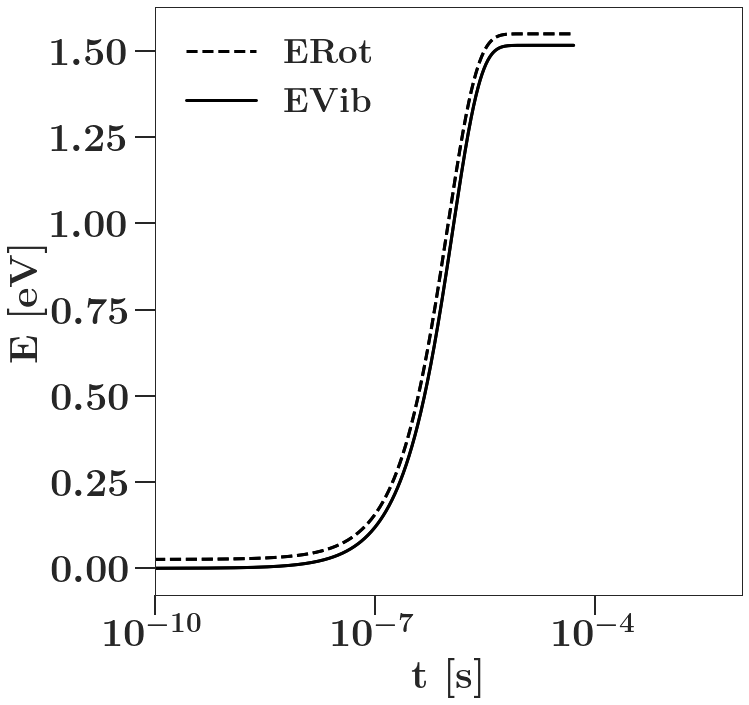

In [13]:
# from Plots import Plot_MoleFraction
# MoleFractionXLim=[[0,5e-6],[0,3e-6],[0,3e-6],[0,3e-7]]
# for iTemp in range(len(TempVec)):                                                                                                                                                                                                                        
#     Temp = TempVec[iTemp] 
#     fig = Plot_MoleFraction(System,QCT[iTemp],SurQCT[iTemp],TempVec,MoleFractionXLim[iTemp])
#     plt.savefig((Figure_ME_path+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgSurQCT+'_X.eps'), format='eps')

# MoleFractionXLim=[[1e-9,1e-3],[0,3e-6],[0,3e-6],[0,3e-7]]

# MoleFractionXLim=[[1e-9,1e-3],[0,3e-6],[0,3e-6],[0,3e-7]]
# fig = Plot_MoleFraction_allTemp(System,QCT,SurQCT,TempVec,MoleFractionXLim[0])
# plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_X.pdf'), format='pdf', dpi=600)

EnergyXLim=[1e-10,1e-2]
fig = Plot_Energies(System,QCT,TempVec,EnergyXLim)


In [14]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 15
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 15
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 25

<ipython-input-14-6b0d84f6bdee>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


In [15]:
# Population plot times                                                                                                                                                                                                                                      
def find_nearest(array, value):                                                                                                                                                                                                                              
    i = 0                                                                                                                                                                                                                                                    
    iStep=[]                                                                                                                                                                                                                                                 
    for ivalue in value:                                                                                                                                                                                                                                     
        array = np.asarray(array)                                                                                                                                                                                                                            
        idx = (np.abs(array - ivalue)).argmin()                                                                                                                                                                                                              
        iStep.append(idx)                                                                                                                                                                                                                                    
        i = i+1                                                                                                                                                                                                                                              
    return iStep   

def Plot_Populations(TempVec,plot_times,QSSFlg,QCT):                                                                                                                                                                                         
    
    fig,ax = plt.subplots(2,1,figsize=(15,12),sharex=True)
    iplot = 0
    for iTemp in range(len(TempVec)-1):   
        iTemp = iTemp + 1
        Temp = TempVec[iTemp]
        if(QSSFlg): 
            iStepVec = find_nearest(QCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                               
        else:
            iStepVec = find_nearest(QCT[iTemp].time, plot_times)          
        
        for iStep in iStepVec:                                                                                                                                                                                                 
            print(iStep)                                                                                                                                                                                      
            cmap=mpl.colors.ListedColormap(["k","mediumvioletred","slategray","yellowgreen","sandybrown","sienna","b","c","g","cyan","navy","crimson","limegreen","gold","r","y"])                                                         

            cp = ax[iplot].scatter(DiatData[0]['EInt'], PopQCT[iTemp].Pop_g[iStep,:], c='k',label='\\textbf{QCT}')                                                                                                                                
            
            ax[iplot].set_yscale('log') 
#             ax[iplot].set_yticks([1e12,1e14,1e16,1e18,1e20])

        iplot =+ 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
#     plt.xlim([-8,-6])
    plt.yticks([])
    plt.xlabel('$\epsilon$ \\textbf{[eV]}',labelpad=50)                                                                                                                                                                                                  
    plt.ylabel('$N_i/g_i$ \\textbf{[m}$^{-3}$\\textbf{]}',labelpad=80)  

    lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot)]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]   
    fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.8, 0.85),handletextpad=0.1)
    

    return fig                                                                                                                                                                                                                     


In [16]:
# Population plot times                                                                                                                                                                                                                                      
def find_nearest(array, value):                                                                                                                                                                                                                              
    i = 0                                                                                                                                                                                                                                                    
    iStep=[]                                                                                                                                                                                                                                                 
    for ivalue in value:                                                                                                                                                                                                                                     
        array = np.asarray(array)                                                                                                                                                                                                                            
        idx = (np.abs(array - ivalue)).argmin()                                                                                                                                                                                                              
        iStep.append(idx)                                                                                                                                                                                                                                    
        i = i+1                                                                                                                                                                                                                                              
    return iStep   

def Plot_Populations(TempVec,plot_times,QSSFlg,QCT):                                                                                                                                                                                         
    
    fig,ax = plt.subplots(2,1,figsize=(15,12),sharex=True)
    iplot = 0

    for iTemp in range(len(TempVec)):                                                                                                                                                                                                                        
        Temp = TempVec[iTemp]
        if(QSSFlg): 
            iStepVec = find_nearest(QCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                          
        else:
            iStepVec = find_nearest(QCT[iTemp].time, plot_times)   
            
        
    for iStep in iStepVec:                                                                                                                                                                                                 
        print(iStep)                                                                                                                                                                                      
        cmap=mpl.colors.ListedColormap(["k","mediumvioletred","slategray","yellowgreen","sandybrown","sienna","b","c","g","cyan","navy","crimson","limegreen","gold","r","y"])
        v_color = DiatData[0]['vqn']
    
        cp = ax[iplot].scatter(DiatData[0]['EInt'], PopQCT[iTemp].Pop_g[iStep,:], c=v_color,cmap=cmap,label='\\textbf{QCT}')  
        ax[iplot].set_yscale('log') 

        iplot =+ 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('$\epsilon$ \\textbf{[eV]}',labelpad=50)                                                                                                                                                                                                  
    plt.ylabel('$N_i/g_i$ \\textbf{[m}$^{-3}$\\textbf{]}',labelpad=100)  

    lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot)]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]   
    fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.8, 0.85),handletextpad=0.1)                                                                                                                                                                                                                    

    return fig        

645
954


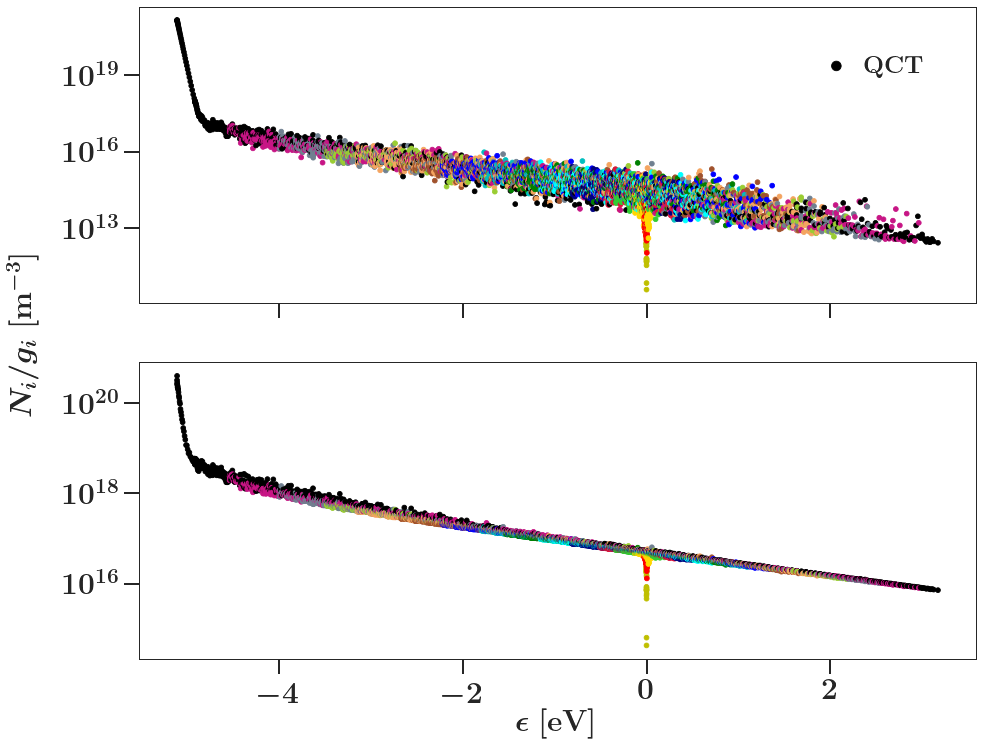

In [17]:
# from Plots import Plot_Populations, Plot_Populations_vcolor, Plot_Populations_ecbcolor 
plot_times=[1e-8,1e-6]
QSSFlg=False
TransVec = [20000]
fig=Plot_Populations(TransVec,plot_times,QSSFlg,QCT)                                                                                                      
                                                                                                    